In [25]:
import numpy as np

inputs = [
    [1.0, 2.0, 3.0, 2.5], 
    [2.0, 5.0, -1.0, 2.0],
    [-1.5, 2.7, 3.3, -0.8]
] 

weights = [
    [0.2, 0.8, -0.5, 1.0],
    [0.5, -0.91, 0.26, -0.5],
    [-0.26, -0.27, 0.17, 0.87]
] 

biases = [2.0, 3.0, 0.5]

layer_outputs = np.dot(inputs, np.array(weights).T) + biases
layer_outputs

AttributeError: 'list' object has no attribute 'astype'

In [ ]:
pip install nnfs


[notice] A new release of pip is available: 23.3.2 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from nnfs.datasets import spiral_data
import nnfs
import matplotlib.pyplot as plt

In [ ]:
nnfs.init()


In [27]:
class Layer_Dense:

    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

class Activation_ReLU:
    
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Activation_Softmax:

    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)
        self.output = probabilities
        
    def backward(self, dvalues):

        self.dinputs = np.empty_like(dvalues)
        
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = np.array(single_output).reshape(-1, 1)
            print(single_output)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            print(jacobian_matrix)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

class Loss:

    def calculate(self, output, y):

        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_CategoricalCrossentropy(Loss):

    def forward(self, y_pred, y_true):

        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    def backward(self, dvalues, y_true):

        samples = len(dvalues)
        labels = len(dvalues[0])
        
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs/samples

# final layer of neural network, combining classification layer and loss function calculation for simplification purposes
# takes as its input the output of the second dense layer (is this a matrix? why?)
# outputs a classification based on output of second dense layer and then loss is calculated based on this classification
class Activation_Softmax_Loss_CategoricalCrossentropy():

    def __init__(self):

        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # takes as input, the output of the second layer and creates a classification
    # then calculates loss based on how wrong this classification is
    def forward(self, inputs, y_true):

        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)
    
    # final output is loss for classifcation of each batch (or is it called sample?) and input is all outputs of second dense layer
    # so gradients is partial derivate of loss with respect to every input from second dense layer
    # partial derivative = predicted probabilities - ground truth probabilities
    def backward(self, dvalues , y_true) -> None:

        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        # normalises gradient 
        # if we had n samples in the predicted probabilities matrix then we subtract n from it in total, as from each sample we subtract 1 (the value of the ground truth)
        # so to normalise gradient we have to divide it by n
        #gradient_matrix_row[i] / n is normalised 
        self.dinputs = self.dinputs/samples

class Optimizer_SGD:

    def __init__(self, learning_rate=1.0, decay=0, momentum=0):
        
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    def pre_udpate_params(self):

        # before each update, decay learning rate by one iteration

        if self.decay:
            self.current_learning_rate = self.learning_rate * (1 / (1+self.decay*self.iterations))

    def update_params(self, layer):

        if self.momentum:

        # SDG with momentum:
        # parameters = parameters + ( (momentum * previous updates) - (learning rate * parameter gradients) )
        
        # update contains a portion of the gradient from preceding steps and only a portion o the current gradient
        # together these portions form the update to our parameters
        # the larger the momentum, the slower the update can change the direction

            if not hasattr(layer, 'weight_momentums'):

                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        
        else:   
            # vanilla SDG: parameters = parameters - (learning_rate * parameter gradient)
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_udpate_params(self):
        
        self.iterations += 1

class Optimizer_Adagrad:

    def __init__(self, learning_rate=1.0, decay=0, epsilon = 1e-7):
        
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    def pre_udpate_params(self):

        # before each update, decay learning rate by one iteration

        if self.decay:
            self.current_learning_rate = self.learning_rate * (1 / (1+self.decay*self.iterations))

    def update_params(self, layer):

        # keep cache of squared gradients
        # objective is to normalize parameter updates, the bigger the sum of the updates, in positive or negative direction, the smaller updates are made further in training
        # let's less frequently updated parameters keep up with training, effectively using more neurons for training

        if not hasattr(layer, 'weight_cache'):

            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # larger gradient magnitude, means larger parameter update so cache for that increases
        # this means next updates will be smaller
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache)+self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache)+self.epsilon)

    def post_udpate_params(self):
        
        self.iterations += 1

class Optimizer_RMSprop:

    def __init__(self, learning_rate=0.001, decay=0, epsilon = 1e-7, rho=0.9):
        
        self.learning_rate = learning_rate 
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    def pre_udpate_params(self):

        # before each update, decay learning rate by one iteration

        if self.decay:
            self.current_learning_rate = self.learning_rate * (1 / (1+self.decay*self.iterations))

    def update_params(self, layer):

        # RMSProp uses a moving average of the cache so that the cache contents move with time and learning does not stall
        # Each cache updates retains a part of the cache and updates it with a fraction of the new squared gradients
        # the hyper-parameter rho decides how much of old cache we keep and how much new gradients change cache

        if not hasattr(layer, 'weight_cache'):

            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_cache = self.rho * layer.weight_cache + (1-self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + (1-self.rho) * layer.dbiases**2

        # like with Adagrad, since we're dividing by cache, slows down updates to parameters that have already updated a lot

        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache)+self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache)+self.epsilon)

    def post_udpate_params(self):
        
        self.iterations += 1

class Optimizer_Adam:

    def __init__(self, learning_rate=0.001, decay=0, epsilon = 1e-7, beta_1=0.9, beta_2=0.999):
        
        self.learning_rate = learning_rate 
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_udpate_params(self):

        # before each update, decay learning rate by one iteration

        if self.decay:
            self.current_learning_rate = self.learning_rate * (1 / (1+self.decay*self.iterations))

    def update_params(self, layer):

        # Adam uses learning decay, updates parameters with paramter momentums instead of gradients, a cache and a bias correction mechanism for initial iterations

        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # instead of applying current parameter gradients to cache, we apply momentums
        # momentum has part of previous parameter momentums and part of current gradient, beta_1 decides how much of each

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        # with previous caches and momentums, the initial iterations are impacted by the zero-valued start before they warm up with the initial steps
        # Adam fixes this, by dividing momentums and caches by (1-beta^step) 
        # so initialiy we are artificially increasing momentum and cache to speed up training in initial stages

        weight_momentums_corrected = layer.weight_momentums / (1-self.beta_1 ** (self.iterations+1))
        bias_momentums_corrected = layer.bias_momentums / (1-self.beta_1 ** (self.iterations+1))

        #cache updates work in the same way as for Adagrad. cache is updated with portion of old cache and portion of current gradients, portion decided by beta_2 hyperparameter
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1-self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1-self.beta_2) * layer.dbiases**2


        # correct cache with initial bias correcting mechanism
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # learning rate multiplied by parameter momentums instead of gradients and then cache normalisation is as usual
        # like with Adagrad, since we're dividing by cache, slows down updates to parameters that have already updated a lot
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected)+self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected)+self.epsilon)

    def post_udpate_params(self):
        
        self.iterations += 1

In [28]:
true = np.array([0, 1])
pred = np.array([[0.8, 0.2], [0.3, 0.7]])
samples = len(pred)
pred_clipped = np.clip(pred, 1e-7, 1-1e-7)
if len(true.shape) == 1:
    correct_confidences = pred_clipped[
                    range(samples),
                    true]       
correct_confidences


array([0.8, 0.7])

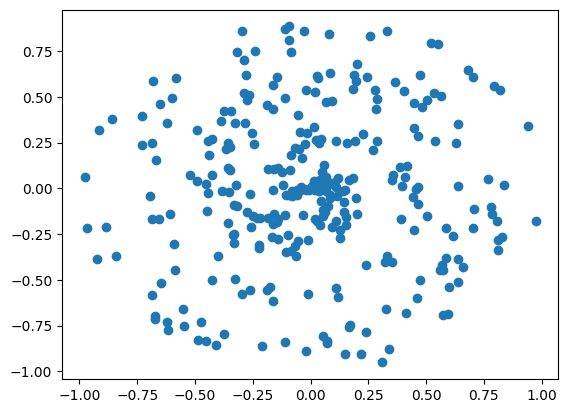

In [29]:
X, y = spiral_data(samples=100, classes=3)
plt.scatter(X[:,0], X[:,1]) 
plt.show()

In [30]:
optimizer = Optimizer_RMSprop(learning_rate=0.02, decay=1e-4, rho=0.999)
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

for epoch in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)

    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)
    if not epoch % 1000:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f' loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')

    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    optimizer.pre_udpate_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_udpate_params()



epoch: 0, acc: 0.260,  loss: 1.099, lr: 0.02
epoch: 1000, acc: 0.770,  loss: 0.498, lr: 0.018183471224656786
epoch: 2000, acc: 0.810,  loss: 0.361, lr: 0.016668055671305942
epoch: 3000, acc: 0.883,  loss: 0.291, lr: 0.015385798907608278
epoch: 4000, acc: 0.923,  loss: 0.220, lr: 0.014286734766769053
epoch: 5000, acc: 0.943,  loss: 0.185, lr: 0.013334222281485434
epoch: 6000, acc: 0.947,  loss: 0.165, lr: 0.01250078129883118
epoch: 7000, acc: 0.950,  loss: 0.151, lr: 0.011765397964586153
epoch: 8000, acc: 0.947,  loss: 0.144, lr: 0.011111728429357186
epoch: 9000, acc: 0.947,  loss: 0.135, lr: 0.010526869835254487
epoch: 10000, acc: 0.943,  loss: 0.126, lr: 0.010000500025001252


In [31]:



activation1.forward(dense1.output)
print(activation1.output[:5])

[[0.         0.         0.         0.         0.         0.4922287
  0.         0.         0.         0.         0.         0.
  0.         0.56910783 0.         0.         0.         0.
  0.         0.         0.         0.         1.8005913  0.
  0.         0.         0.         0.         0.         0.
  0.         0.7091483  0.         0.         0.         2.5282142
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         2.2669609  0.         0.         0.         1.9854008
  0.         0.         0.         1.4699218  0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.588457
  0.         0.         0.         0.         0.         0.
  0.         0.5111399  0.         0.         0.         0.
  0.         0.         0.         0.         1.7836837  0.
  0.         0.         0.         0.         0.         0.
  0.         0.74402994 0.

In [ ]:
softmax_outputs = np.array([[0.7, 0.2, 0.1],
                            [0.5, 0.1, 0.4],
                            [0.02, 0.9, 0.08]])
class_targets = np.array([0, 1, 1])

predictions = np.argmax(softmax_outputs, axis=1)
print(predictions)
print(predictions==class_targets)
accuracy = np.mean(predictions==class_targets)
accuracy

[0 0 1]
[ True False  True]


0.6666666666666666

In [ ]:
import numpy as np

In [ ]:
a = np.array([[1,2,3,4],
              [5,6,7,8],
              [9,10,11,12]])

In [ ]:
a.transpose()

array([[ 1,  5,  9],
       [ 2,  6, 10],
       [ 3,  7, 11],
       [ 4,  8, 12]])

In [32]:
soft = Activation_Softmax()
dvalues = [[0.1, 0.2, 0.31],
           [0.14, 0.42, 0.31],
           [0.11, 0.22, 0.1]]
soft.output = [[0.1, 0.2, 0.31],
           [0.14, 0.42, 0.31],
           [0.11, 0.22, 0.1]]
soft.backward(dvalues)


[[0.1 ]
 [0.2 ]
 [0.31]]
[[ 0.09   -0.02   -0.031 ]
 [-0.02    0.16   -0.062 ]
 [-0.031  -0.062   0.2139]]


AttributeError: 'list' object has no attribute 'astype'

In [33]:
import numpy as np

In [50]:
single_output = np.array([[0.1, 0.2],
                [0.2, 0.1],
                [0.31, 0.4]])
single_output.reshape(-1,1)

array([[0.1 ],
       [0.2 ],
       [0.2 ],
       [0.1 ],
       [0.31],
       [0.4 ]])

In [59]:
print(single_output)
len(single_output)

[[0 0 1]
 [0 1 0]
 [0 1 0]]


3

In [67]:
dinputs = np.array([[0.2, 0.1, 0.7],
                    [0.3, 0.6, 0.1],
                    [0.8, 0.1, 0.1]])
y_true = np.array([[0,0,1],
                    [0,1,0],
                    [0,1,0]])
y_true = np.argmax(y_true, axis=1)
dinputs[range(3), y_true] -= 1
dinputs = dinputs 
dinputs

array([[ 0.2,  0.1, -0.3],
       [ 0.3, -0.4,  0.1],
       [ 0.8, -0.9,  0.1]])